In [1]:
import tensorflow
!nvidia-smi
#12.7 GB RAM
# 15.0 GB GPU
!python ‐‐version
!pip show keras
print(tensorflow.__version__)

Wed Mar 29 13:53:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

colab = True
name = "0091-GAN-0056"

if not colab: 
  train_dir = r'G:\Mi unidad\Uni\Cuarto curso\Primer cuatrimestre\TFG\WebScrapping\train'
  validation_dir = r'G:\Mi unidad\Uni\Cuarto curso\Primer cuatrimestre\TFG\WebScrapping\validation'
  test_dir = r'G:\Mi unidad\Uni\Cuarto curso\Primer cuatrimestre\TFG\WebScrapping\test'

else:
  train_dir = r'/content/drive/MyDrive/dataset2/train'
  validation_dir = r'/content/drive/MyDrive/dataset2/validation'
  test_dir = r'/content/drive/MyDrive/dataset2/test'

  gray_train_dir = r'/content/drive/MyDrive/dataset2/gray-train'
  gray_validation_dir = r'/content/drive/MyDrive/dataset2/gray-validation'
  gray_test_dir = r'/content/drive/MyDrive/dataset2/gray-test'


  gray_mini_test_dir = r'/content/drive/MyDrive/mini_test_2'

batch_size = 1
img_height = 512 #1792
img_width = 512 #1280
img_gen = ImageDataGenerator()

train_gen = img_gen.flow_from_directory(train_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input", shuffle = False)
validation_gen = img_gen.flow_from_directory(validation_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input", shuffle = False)
test_gen = img_gen.flow_from_directory(test_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input", shuffle = False)

gray_train_gen = img_gen.flow_from_directory(gray_train_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input", shuffle = False)
gray_validation_gen = img_gen.flow_from_directory(gray_validation_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input", shuffle = False)
gray_test_gen = img_gen.flow_from_directory(gray_test_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input", shuffle = False)


mini_test_gen = img_gen.flow_from_directory(gray_mini_test_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input", shuffle = False)
gray_mini_test_gen = img_gen.flow_from_directory(gray_mini_test_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input", shuffle = False)


Found 1671 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 1671 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [33]:
mini_test_gen = img_gen.flow_from_directory(gray_mini_test_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input", shuffle = False)
gray_mini_test_gen = img_gen.flow_from_directory(gray_mini_test_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input", shuffle = False)

Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [12]:
import tensorflow as tf

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2,batch_size, 256, 256, 3])

  return cropped_image[0], cropped_image[1]

def pair_generator(gray, color):
  while True:
    g = next(gray)[0]
    c = next(color)[0]

    ccrop_g, crop_c = random_crop(g,c)
    yield ((ccrop_g /127.5) - 1),  ((crop_c / 127.5) - 1)

In [5]:
a,b = next(pair_generator(gray_train_gen, train_gen))
print(a.shape, b.shape)

(2, 1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)


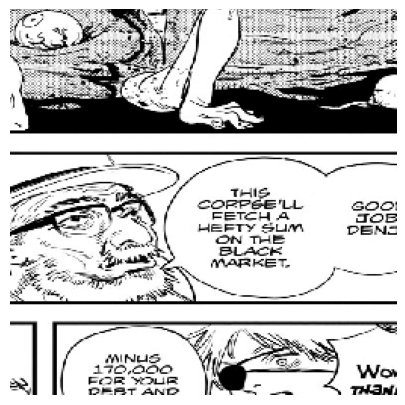

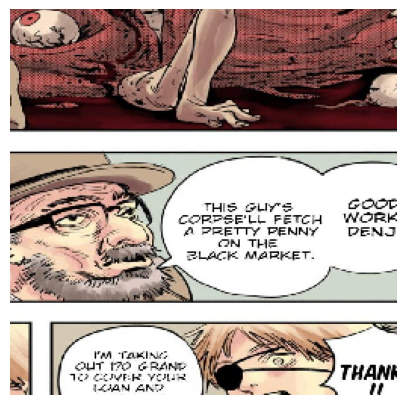

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
plt.axis('off')
plt.imshow(a[0]*0.5 + 0.5, cmap = 'gray')
plt.show()

plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
plt.axis('off')
plt.imshow(b[0]*0.5 + 0.5)
plt.show()

In [7]:
# example of defining a composite model for training the generator model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the discriminator model
def define_discriminator(gray_image_shape, RGB_image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 123)
	# source image input
	in_src_image = Input(shape=gray_image_shape)
	# target image input
	in_target_image = Input(shape=RGB_image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 1)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 2)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 5)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image, name="generator" )
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, gray_image_shape, RGB_image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_gray = Input(shape=gray_image_shape, name = "in_gray")
	in_RGB = Input(shape=RGB_image_shape, name = "in_RGB")
	
	# connect the source image to the generator input
	gen_out = g_model(in_gray)
	
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_gray, gen_out])

	# src image as input, generated image and classification output
	model = Model(in_gray, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# define image shape
gray_image_shape=(256,256,3)
RGB_image_shape=(256,256,3)
# define the models
d_model = define_discriminator(gray_image_shape, RGB_image_shape)
g_model = define_generator(gray_image_shape)
#d_model.summary()
#g_model.summary()
# define the composite model
gan_model = define_gan(g_model, d_model, gray_image_shape, RGB_image_shape)
# summarize the model
#gan_model.summary()
# plot the model
#plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
n_steps = 20000
n_validation = 25
index = 0
history = {"g_loss":[0.0]*(n_steps//n_validation),
	          "d_loss":[0.0]*(n_steps//n_validation)}

In [9]:
import numpy as np
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, i, n_samples, patch_shape):
	# unpack dataset
	#trainA, trainB = dataset
	trainA, trainB = next(dataset)
	# choose random instances
	#ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA, trainB
	# generate 'real' class labels (1)
	y = np.ones((trainA.shape[0], patch_shape[0], patch_shape[1], 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape[0], patch_shape[1], 1))
	return X, y

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_steps, n_validation, n_batch, n_patch, index):
	# unpack dataset
	#n_patch = (112,80)
	#trainA, trainB = dataset
	# calculate the number of batches per training epoch
	#bat_per_epo = int(len(trainA) / n_batch)
	bat_per_epo = 2000
	# calculate the number of training iterations
	
	print(index)
	history_d_loss1 = 0
	history_d_loss2 = 0
	history_g_loss = 0 

	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, i, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples


		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		_, g_loss, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
	
		history_d_loss1 = history_d_loss1 + d_loss1
		history_d_loss2 = history_d_loss2 + d_loss2
		history_g_loss = history_g_loss + g_loss 

		# summarize performance
	
		
		if (i+1) % n_validation == 0  and i != 0:
			history["d_loss"][index] = (history_d_loss2/n_validation)
			history["g_loss"][index] = (history_g_loss/n_validation)

			history_d_loss1 = 0
			history_d_loss2 = 0
			history_g_loss = 0

			print(i+1)
			index = index + 1


In [37]:
def save(name, p, i):
  save = r'/content/drive/MyDrive/'
  plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  plt.axis('off')
  plt.imshow(p[0]*0.5 + 0.5)
  #plt.show()
  plt.savefig( save + 'images0104/'  + str(i)  +'-'+ name +  ".jpeg", bbox_inches='tight')

In [13]:
train(d_model, g_model, gan_model, dataset = pair_generator(gray_train_gen, train_gen),
      n_batch = batch_size,n_steps = 1000, n_validation = 25, n_patch = (16, 16), index = 0)

0
1/1 [==============================] - 0s 22ms/step
25
1/1 [==============================] - 0s 23ms/step
50
1/1 [==============================] - 0s 24ms/step
75
1/1 [==============================] - 0s 23ms/step
100
1/1 [==============================] - 0s 37ms/step
125
1/1 [==============================] - 0s 24ms/step
150
1/1 [==============================] - 0s 21ms/step
175
1/1 [==============================] - 0s 26ms/step
200
1/1 [==============================] - 0s 34ms/step
225
1/1 [==============================] - 0s 25ms/step
250
1/1 [==============================] - 0s 26ms/step
275
1/1 [==============================] - 0s 23ms/step
300
1/1 [==============================] - 0s 25ms/step
325
1/1 [==============================] - 0s 24ms/step
350
1/1 [==============================] - 0s 24ms/step
375
1/1 [==============================] - 0s 23ms/step
400
1/1 [==============================] - 0s 46ms/step
425
1/1 [==============================] - 0s 23ms/st

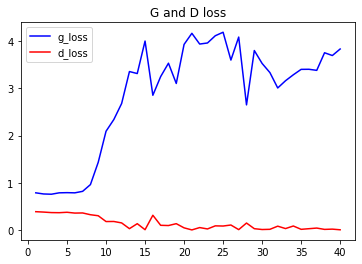

In [14]:
import matplotlib.pyplot as plt

index = 40
g_loss = history['g_loss'][:index]
d_loss = history['d_loss'][:index]
epochs = range(1, len(g_loss) + 1)

plt.plot(epochs, g_loss, 'b', label='g_loss')
plt.plot(epochs, d_loss, 'r', label='d_loss')
plt.title('G and D loss')
plt.legend()
plt.show()

In [34]:
name = "0104-GAN-0069-1000"
save1 = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
"""d_model.save(save1 + "d-"+ name, include_optimizer=True)
g_model.save(save1 + "g-"+ name, include_optimizer=True)
gan_model.save(save1 + "gan-" + name, include_optimizer=True)

import json
with open(save1 + name + ".json", "w") as outfile:
    json.dump(history, outfile)
"""
from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(10): 
  a,b = next(pair_generator(gray_mini_test_gen, mini_test_gen))
  p = g_model.predict(a)
  save(name, p, i)
  #

Output hidden; open in https://colab.research.google.com to view.

In [35]:
train(d_model, g_model, gan_model, dataset = pair_generator(gray_train_gen, train_gen),
      n_batch = batch_size,n_steps = 1000, n_validation = 25, n_patch = (16, 16), index = 40)

40
1/1 [==============================] - 0s 25ms/step
25
1/1 [==============================] - 0s 25ms/step
50
1/1 [==============================] - 0s 23ms/step
75
1/1 [==============================] - 0s 22ms/step
100
1/1 [==============================] - 0s 21ms/step
125
1/1 [==============================] - 0s 41ms/step
150
1/1 [==============================] - 0s 22ms/step
175
1/1 [==============================] - 0s 22ms/step
200
1/1 [==============================] - 0s 23ms/step
225
1/1 [==============================] - 0s 56ms/step
250
1/1 [==============================] - 0s 25ms/step
275
1/1 [==============================] - 0s 32ms/step
300
1/1 [==============================] - 0s 32ms/step
325
1/1 [==============================] - 0s 23ms/step
350
1/1 [==============================] - 0s 22ms/step
375
1/1 [==============================] - 0s 45ms/step
400
1/1 [==============================] - 0s 23ms/step
425
1/1 [==============================] - 0s 24ms/s

In [40]:
import matplotlib.pyplot as plt

index = 80
g_loss = history['g_loss'][:index]
d_loss = history['d_loss'][:index]
epochs = range(1, len(g_loss) + 1)

plt.plot(epochs, g_loss, 'b', label='g_loss')
plt.plot(epochs, d_loss, 'r', label='d_loss')
plt.title('G and D loss')
plt.legend()
plt.show()

name = "0104-GAN-0069-2000"
save1 = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
"""d_model.save(save1 + "d-"+ name, include_optimizer=True)
g_model.save(save1 + "g-"+ name, include_optimizer=True)
gan_model.save(save1 + "gan-" + name, include_optimizer=True)

import json
with open(save1 + name + ".json", "w") as outfile:
    json.dump(history, outfile)
"""
from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(10): 
  a,b = next(pair_generator(gray_mini_test_gen, mini_test_gen))
  p = g_model.predict(a)
  save(name, p, i)
  #

Output hidden; open in https://colab.research.google.com to view.

In [43]:
train(d_model, g_model, gan_model, dataset = pair_generator(gray_train_gen, train_gen),
      n_batch = batch_size,n_steps = 5000, n_validation = 25, n_patch = (16, 16), index = 80)

80
1/1 [==============================] - 0s 23ms/step
25
1/1 [==============================] - 0s 22ms/step
50
1/1 [==============================] - 0s 25ms/step
75
1/1 [==============================] - 0s 24ms/step
100
1/1 [==============================] - 0s 21ms/step
125
1/1 [==============================] - 0s 23ms/step
150
1/1 [==============================] - 0s 24ms/step
175
1/1 [==============================] - 0s 26ms/step
200
1/1 [==============================] - 0s 26ms/step
225
1/1 [==============================] - 0s 25ms/step
250
1/1 [==============================] - 0s 26ms/step
275
1/1 [==============================] - 0s 22ms/step
300
1/1 [==============================] - 0s 24ms/step
325
1/1 [==============================] - 0s 23ms/step
350
1/1 [==============================] - 0s 23ms/step
375
1/1 [==============================] - 0s 38ms/step
400
1/1 [==============================] - 0s 22ms/step
425
1/1 [==============================] - 0s 24ms/s

KeyboardInterrupt: ignored

In [44]:
import matplotlib.pyplot as plt

index = 200
g_loss = history['g_loss'][:index]
d_loss = history['d_loss'][:index]
epochs = range(1, len(g_loss) + 1)

plt.plot(epochs, g_loss, 'b', label='g_loss')
plt.plot(epochs, d_loss, 'r', label='d_loss')
plt.title('G and D loss')
plt.legend()
plt.show()

name = "0104-GAN-0069-5000"
save1 = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save1 + "d-"+ name, include_optimizer=True)
g_model.save(save1 + "g-"+ name, include_optimizer=True)
#gan_model.save(save1 + "gan-" + name, include_optimizer=True)

import json
with open(save1 + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(10): 
  a,b = next(pair_generator(gray_mini_test_gen, mini_test_gen))
  p = g_model.predict(a)
  save(name, p, i)
  #

Output hidden; open in https://colab.research.google.com to view.

In [61]:
train(d_model, g_model, gan_model, dataset = pair_generator(gray_train_gen, train_gen),
      n_batch = batch_size,n_steps = 2000, n_validation = 25, n_patch = (16, 16), index = 200)

200
1/1 [==============================] - 0s 27ms/step
25
1/1 [==============================] - 0s 42ms/step
50
1/1 [==============================] - 0s 27ms/step
75
1/1 [==============================] - 0s 24ms/step
100
1/1 [==============================] - 0s 28ms/step
125
1/1 [==============================] - 0s 39ms/step
150
1/1 [==============================] - 0s 26ms/step
175
1/1 [==============================] - 0s 27ms/step
200
1/1 [==============================] - 0s 27ms/step
225
1/1 [==============================] - 0s 42ms/step
250
1/1 [==============================] - 0s 40ms/step
275
1/1 [==============================] - 0s 34ms/step
300
1/1 [==============================] - 0s 34ms/step
325
1/1 [==============================] - 0s 38ms/step
350
1/1 [==============================] - 0s 25ms/step
375
1/1 [==============================] - 0s 25ms/step
400
1/1 [==============================] - 0s 26ms/step
425
1/1 [==============================] - 0s 41ms/

In [62]:
import matplotlib.pyplot as plt

index = 280
g_loss = history['g_loss'][:index]
d_loss = history['d_loss'][:index]
epochs = range(1, len(g_loss) + 1)

plt.plot(epochs, g_loss, 'b', label='g_loss')
plt.plot(epochs, d_loss, 'r', label='d_loss')
plt.title('G and D loss')
plt.legend()
plt.show()

name = "0104-GAN-0069-7000"
save1 = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save1 + "d-"+ name, include_optimizer=True)
g_model.save(save1 + "g-"+ name, include_optimizer=True)
#gan_model.save(save1 + "gan-" + name, include_optimizer=True)

import json
with open(save1 + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(10): 
  a,b = next(pair_generator(gray_mini_test_gen, mini_test_gen))
  p = g_model.predict(a)
  save(name, p, i)
  #

Output hidden; open in https://colab.research.google.com to view.

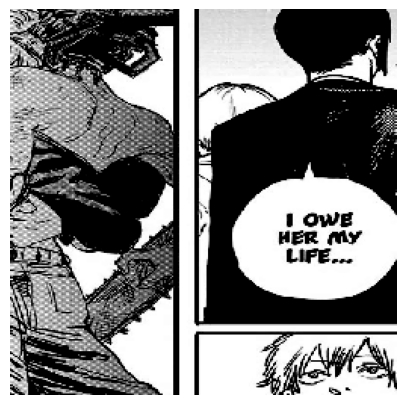

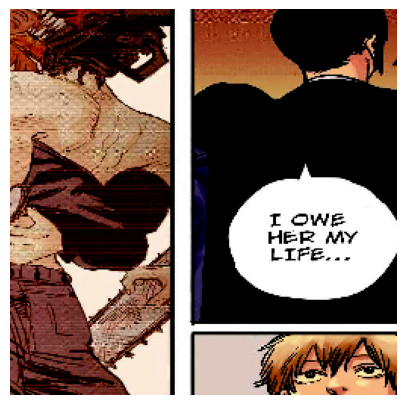

In [45]:
for i in range(1): 
  a,b = next(pair_generator(gray_train_gen, train_gen))
  plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  plt.axis('off')
  plt.imshow(a[0], cmap = 'gray')
  #plt.show()
  plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  plt.axis('off')
  plt.imshow(b[0])


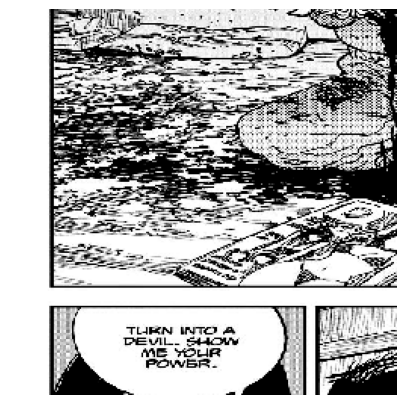

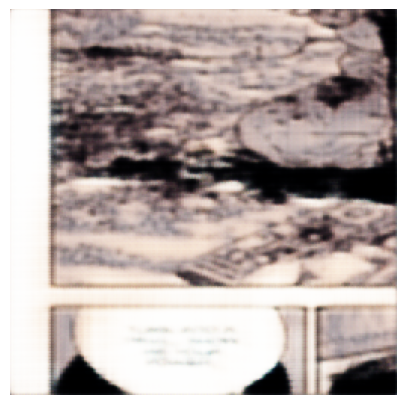

In [60]:
for i in range(1): 
  a,b = next(pair_generator(gray_train_gen,train_gen))
  plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  plt.axis('off')
  plt.imshow(a[0], cmap = 'gray')

  p = g_model(a)
  plt.show()
  plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  plt.axis('off')
  plt.imshow(p[0]*0.5 + 0.5)
